In [1]:
# transformer的结构
# encoder 嵌入 -> 位置编码 -> 多头 ->  res+norm -> 前馈 -> res+norm
# decoder 嵌入 -> 位置编码 -> 掩蔽多头 -> res+norm -> (  多头 | 注意力 ) -> res+norm -> 前馈 -> res+norm -> MLP

In [2]:
# 从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的
# 每个层都有两个子层（子层表示为sublayer）。
# 1.第一个子层是多头自注意力（multi-head self-attention）汇聚
# 2.第二个子层是基于位置的前馈网络（positionwise feed-forward network）

# Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。
# 除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层
# 称为编码器－解码器注意力（encoder-decoder attention）层。
# 在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。
# 在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。
# 这种掩蔽（masked）注意力保留了自回归（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

In [3]:
import math
import os
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [4]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = d2l.preprocess_nmt(read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = d2l.build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f: 
        return f.read()

In [5]:
# 基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP）
# 这就是称前馈网络是基于位置的（positionwise）的原因。
# input (B, step/Q/K, num_hiddens)
# output (B, step, output_dim)

#@save
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(**kwargs)
        # 前馈本质就是两层的MLP, 把维度提高，再把维度降低，试图学到更高层次的变换
        # output = W2 * ReLU(W1x + b1) + b2 
        # 通常的，input_dim = output_dim = num_hiddens
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        # net(X) 本质上就是在调用 __call__魔术方法
        return self.dense2(self.relu(self.dense1(X)))

In [6]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0].shape # dim (2, 3, 4) for (B, step, d)

torch.Size([3, 8])

##### 现在让我们关注加法和规范化的组件

In [7]:
# 层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。
# 尽管批量规范化在计算机视觉中被广泛应用
# 但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。
# LayerNorm > BatchNorm
# 1.批量可能很小，并且序列不定长
# 2.分布差异会很大

In [8]:
# test

ln = nn.LayerNorm(3) # 最后一个维度的shape
bn = nn.BatchNorm1d(3) # feartures的shape
X = torch.tensor([[1, 2, 3], [2, 3, 4]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print(X.shape, '\n', 'layer norm:', ln(X), '\nbatch norm:', bn(X))

torch.Size([2, 3]) 
 layer norm: tensor([[-1.2247,  0.0000,  1.2247],
        [-1.2247,  0.0000,  1.2247]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [9]:
# 使用残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用

#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout()
        self.ln = nn.LayerNorm(normalized_shape)

    # X 表示残差链接,Y是子层的输出
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [10]:
add_norm = AddNorm([3, 4], 0.1)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

##### 编码器

In [11]:
# 下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络
# 这两个子层都使用了残差连接和紧随的层规范化。

#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                dropout, use_bias=False, **kwargs):
        # 很显然，这里 output_size = input_size
        super().__init__(**kwargs)
        # MultiHeadAttention - see in 10-5
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias
        )
        # 一个encode*1的流程:
        # positional coding - attention - norm1 - ffn - norm2
        self.addNorm1 = AddNorm(norm_shape, dropout=dropout)
        self.addNorm2 = AddNorm(norm_shape, dropout=dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens
        )

    def forward(self, X, valid_lens):
        # 最标准的self-attention:attention(X,X,X,valid_len) KQV = X
        Y = self.addNorm1(X, self.attention(X, X, X, valid_lens))
        return self.addNorm2(X, self.ffn(Y))

In [12]:
# 正如从代码中所看到的，Transformer编码器中的任何层都不会改变其输入的形状。

X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [13]:
# 下面实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。
# 由于这里使用的是值范围在-1和1之间的固定位置编码
# 因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))
            
    def forward(self, X, valid_lens, *args):
        # 首先明确：embedding的范围和positional encoding的幅度必须在同一量级，否则相加后会失衡
        # PE的范围是-1,1之间，而embedding的初始值一般很小，比如~0.01
        # 所以我们要想方法把embedding的数值范围和PE的范围弄得差不多大 （B,len,num_hiddens）
        # 我们称为 Scale embedding trick
        # 我们说尺度相等，如何评价尺度的？用均方根 sqrt(每一项的平方和，除以总项数)
        # 对于embedding, sqrt(1/512) ~0.044
        # 对于PE,每个维度都属于-1~1, sqrt(1/2) ~0.7
        # embedding其实就是在乘以 sqrt(1/dim) 也就是 sqrt(1/num_hiddens)
        # 所以我们想到再给他除回去，或者说是乘sqrt(num_hiddens)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # 位置编码
        # 看流程，每个encoder模块中都是 attention - norm - ffn - norm
        # 建立一个列表，来看每一次encoder的权重
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
            # blk - Multiheadattention - dotproduct
        return X

In [14]:
# 指定了超参数来创建一个两层的Transformer编码器。 
# Transformer编码器输出的形状是（批量大小，时间步数目，num_hiddens）

encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
# input = (batch, seq_len),经过了 embedding变成(B, seq_len, num_hiddens)
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [15]:
# Transformer解码器也是由多个相同的层组成。
# 在DecoderBlock类中实现的每个层包含了三个子层,解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。
# 一个decoder : mask_multihead - norm - multihead - norm - ffn - norm 和decoder大同小异

# 在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。
# seq2seq中，在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。
# 因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。
# 为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数dec_valid_lens
# 以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

In [16]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout=dropout
        )
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout=dropout
        )
        self.addNorm1 = AddNorm(norm_shape, dropout=dropout)
        self.addNorm2 = AddNorm(norm_shape, dropout=dropout)
        self.addNorm3 = AddNorm(norm_shape, dropout=dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)

    # 回顾一下valid_lens的使用过程
    # input = (2, 2, 3) valid_len = [2,3] 两个batch,每一个都是2,3
    # output = (2,3) batch1 的每一行只显示2个数字，batch2的每一行只显示3个数字
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        # state: (enc_outputs, enc_valid_lens, cache)
        # 训练的时候 cache = [None] * num_layers
        # ----------以上都是原文自带的解释

        # key-value的取名其实很精确，因为你也发现了,kv的值在attention计算的时候，是一样的
        # 而为了不一次性维护两个变量，我们就想到了key_value这个变量，来存key == value
        if state[2][self.i] is None:
            key_values = X
        else:
            # dim = (B, T, D) 在序列维度上拼接
            key_values = torch.cat((state[2][self.i], X), axis = 1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, nums_step, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, nums_step + 1, device=X.device).repeat(batch_size, 1)
            # repeat(a, b)表示在第0维复制a遍，第1维复制b遍
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addNorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addNorm2(Y, Y2)
        return self.addNorm3(Z, self.ffn(Z)), state
        # 所有不走else的流程就是训练流程
        # 所有走else线的，都是预测流程

In [17]:
# 为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [18]:
# 现在我们构建了由num_layers个DecoderBlock实例组成的完整的Transformer解码器。
# 最后，通过一个全连接层计算所有vocab_size个可能的输出词元的预测值。
# 解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要

# 上面是单个的decoder,现在创建layers个

In [19]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # X.shape = (B, seq_len) -> (B, seq_len, num_hiddens) -> (B, seq_len, num_hiddens)
        # 我们在这里需要回忆我们在dotattention中的流程
        # equation = QKT / sqrt(d) -> score ->(masked_softmax) attention_weights -> dropout + value
        # score.shape = (B, Q, K) 原因 : transpose 之后 B,Q,L * B,K,L
        # attention_weight 同维
        # 你注意到decoder有自注意力和跨注意力, 所以需要 for i in range(2)
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [20]:
# 在这里，指定Transformer的编码器和解码器都是2层，都使用4头注意力。

loss 0.040, 10787.9 tokens/sec on cuda:0


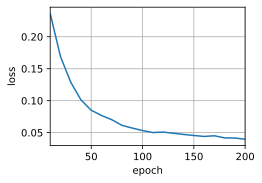

In [21]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [22]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je me suis faible .,  bleu 0.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [23]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
# 接TransformerDecoder(d2l.AttentionDecoder)
# 所以这里的attention_weights.shape (layers, heads, Q, K)
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In [24]:
# 在编码器的自注意力中，查询和键都来自相同的输入序列。
# 因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。
# 接下来，将逐行呈现两层多头注意力的权重。
# 每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。

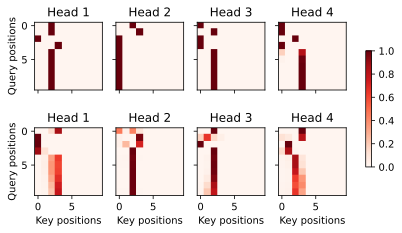

In [25]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [26]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

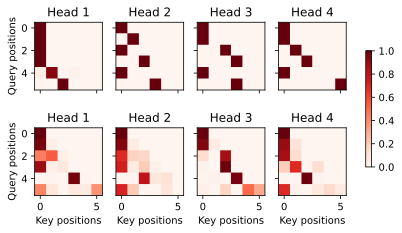

In [27]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))